In [1]:
#from pyscf import gto, scf, fci, lo
#import netket as nk; import netket.experimental as nkx
import numpy as np
#import itertools
import qiskit
#from qiskit.quantum_info import Pauli, SparsePauliOp
from collections import defaultdict
#import tensorflow as tf
import sys
import os
import pandas as pd
#import itertools
from itertools import product
import matplotlib.pyplot as plt
#sys.path.append(os.path.dirname(os.getcwd()) + "/SAMPLER_LOCAL_IMPORT")
#from Sampling_Quantum import *
#from New_MCMC_Proposal import *
#sys.path.append(os.getcwd() + "/Code_download_Bell_2")
from MCMC_funs_Leyden import *

print(qiskit.version.get_version_info())
os.getcwd()

1.0.2


"c:\\Users\\vinit\\Downloads\\Research\\Quantum-Sampling\\Manas' Proposals"

In [ ]:
#Cluster_update_scheme (Swedson-Wang /Wolff type + Local Exchange)
#*****************************************************************


def all_configs(n):
    return [np.array(v) for v in product([-1, 1], repeat=n)]



def Sampling_MCMC_trajectories(problem_inst, Transition_matrix, sample_size=10000, 
                               burn=1000, method='Quantum', init_config=None):

    n = problem_inst.n
    beta = problem_inst.T
    prob_dist = np.zeros(2**n)

    #exact_dist = np.exp(-beta * Proposal_object.Energy_array)
    #exact_dist = exact_dist / np.sum(exact_dist)

    #err_hist = []
    key_list = []

    if init_config==None:
        s = np.random.choice([1,-1],size=n)
    else: s = init_config

    int_key = spinconf2int(s)
    #print(int_key)
    
    for k in range(burn):
        #s = Proposal_object.generate_MCMC_trajectories(Transition_matrix, s)
         int_key = generate_move(transition_mat=Transition_matrix, state=int_key)

    for k in range(sample_size):
        #s = Proposal_object.generate_MCMC_trajectories(Transition_matrix, s)
        int_key = generate_move(transition_mat=Transition_matrix, state=int_key)
        #key = spinconf2int(s)
        prob_dist[int_key] +=1
        key_list.append(int_key)

    
    return np.flip(prob_dist/np.sum(prob_dist)), key_list


def wolff_clustering_flipping_step(v, beta, J, h=None, num_trials=200):
    from collections import defaultdict
    n = len(v)
    counts = defaultdict(int)

    for i in range(n):  # Seed spin
        for _ in range(num_trials):
            visited = np.zeros(n, dtype=bool)
            cluster = [i]
            visited[i] = True

            while cluster:
                j = cluster.pop()
                for k in range(n):
                    print(f"Checking {j} and {k}", visited[k], v[k], v[j], J[j, k])
                    if not visited[k] and v[k] == v[j] and J[j, k] > 0:
                        p_add = 1 - np.exp(-2 * beta * J[j, k])
                        if np.random.rand() < p_add:
                            visited[k] = True
                            cluster.append(k)
                        print(f"\t\t Adding {k} to cluster", cluster, p_add)

            print(i, visited)

            v_new = v.copy()
            v_new[visited] *= -1
            counts[tuple(v_new)] += 1

    total = n * num_trials
    return {k: c / total for k, c in counts.items()}


def Wolff_cluster_Proposal_matrix(problem_inst):
    J_Q = problem_inst.J_quantum
    if np.linalg.norm(J_Q - J_Q.T) > 1e-8:
        print("Warning: J_Q is not symmetric, correcting...")
        J_Q = (J_Q + J_Q.T)  # Ensure symmetry

    h_Q = problem_inst.h_quantum
    n = problem_inst.n
    beta = problem_inst.T
    #print(beta)
    configs = all_configs(n)
    index = {tuple(c): i for i, c in enumerate(configs)}

    Q = np.zeros((2**n, 2**n))

    for v in configs:        
        for num_trials in np.arange(4000, 8000, 1000):
            prop_probs = wolff_clustering_flipping_step(v, beta=beta, J=J_Q, h=h_Q, num_trials=num_trials)
            plt.plot(prop_probs.values(), label=str(num_trials))
            plt.legend()

        break
        i = index[tuple(v)]
        for v_prime, prob in prop_probs.items():
            j = index[v_prime]
            if j != i :
                Q[j, i] = abs(prob)
        
        Q[i, i] = abs(1- sum(Q[:,i]))

    return Q


In [107]:
J_Q = problem_inst.J_quantum
J_Q = (J_Q + J_Q.T)   # Ensure symmetry
n = problem_inst.n
beta = problem_inst.T

configs = all_configs(n)
index = {tuple(c): i for i, c in enumerate(configs)}

Q = np.zeros((2**n, 2**n))

v = np.array([1, -1, 1, -1, 1, 1, -1])  # Example configuration      
wolff_clustering_flipping_step(v, beta=beta, J=J_Q, num_trials=1)

Checking 0 and 0 True 1 1 0.0
Checking 0 and 1 False -1 1 0.19821246830101383
Checking 0 and 2 False 1 1 -0.512043317108658
Checking 0 and 3 False -1 1 -0.35675098750184575
Checking 0 and 4 False 1 1 0.05025718603442853
		 Adding 4 to cluster [] 0.09562788537893563
Checking 0 and 5 False 1 1 -0.009608978239232142
Checking 0 and 6 False -1 1 -0.5276629389096239
0 [ True False False False False False False]
Checking 1 and 0 False 1 -1 0.19821246830101383
Checking 1 and 1 True -1 -1 0.0
Checking 1 and 2 False 1 -1 -0.6981733103837491
Checking 1 and 3 False -1 -1 0.20857883007425465
		 Adding 3 to cluster [] 0.34108297320186887
Checking 1 and 4 False 1 -1 0.5929965751642664
Checking 1 and 5 False 1 -1 -0.02340164607246331
Checking 1 and 6 False -1 -1 -0.23822133835068918
1 [False  True False False False False False]
Checking 2 and 0 False 1 1 -0.512043317108658
Checking 2 and 1 False -1 1 -0.6981733103837491
Checking 2 and 2 True 1 1 0.0
Checking 2 and 3 False -1 1 0.45808524253983196
Chec

{(-1, -1, 1, -1, 1, 1, -1): 0.14285714285714285,
 (1, 1, 1, -1, 1, 1, -1): 0.14285714285714285,
 (1, -1, -1, -1, 1, -1, -1): 0.14285714285714285,
 (1, -1, 1, 1, 1, 1, -1): 0.14285714285714285,
 (1, -1, 1, -1, -1, 1, -1): 0.14285714285714285,
 (1, -1, 1, -1, 1, -1, -1): 0.14285714285714285,
 (1, -1, 1, -1, 1, 1, 1): 0.14285714285714285}

In [98]:
J_Q = problem_inst.J_quantum
n = problem_inst.n
beta = problem_inst.T

configs = all_configs(n)
index = {tuple(c): i for i, c in enumerate(configs)}

Q = np.zeros((2**n, 2**n))

v = np.array([1, -1, 1, -1])  # Example configuration      
wolff_clustering_flipping_step(v, beta=beta, J=J_Q, num_trials=2000), wolff_clustering_flipping_step(v, beta=beta, J=J_Q, num_trials=2000)

Checking 0 and 0 True 1 1 0.0
Checking 0 and 1 False -1 1 0.19821246830101383
Checking 0 and 2 False 1 1 -0.512043317108658
		 Adding 2 to cluster [] -1.7845509851343846
Checking 0 and 3 False -1 1 -0.35675098750184575
0 [ True False False False]
Checking 0 and 0 True 1 1 0.0
Checking 0 and 1 False -1 1 0.19821246830101383
Checking 0 and 2 False 1 1 -0.512043317108658
		 Adding 2 to cluster [] -1.7845509851343846
Checking 0 and 3 False -1 1 -0.35675098750184575
0 [ True False False False]
Checking 0 and 0 True 1 1 0.0
Checking 0 and 1 False -1 1 0.19821246830101383
Checking 0 and 2 False 1 1 -0.512043317108658
		 Adding 2 to cluster [] -1.7845509851343846
Checking 0 and 3 False -1 1 -0.35675098750184575
0 [ True False False False]
Checking 0 and 0 True 1 1 0.0
Checking 0 and 1 False -1 1 0.19821246830101383
Checking 0 and 2 False 1 1 -0.512043317108658
		 Adding 2 to cluster [] -1.7845509851343846
Checking 0 and 3 False -1 1 -0.35675098750184575
0 [ True False False False]
Checking 0 a

({(-1, -1, 1, -1): 0.25,
  (1, 1, 1, -1): 0.161125,
  (1, 1, 1, 1): 0.088875,
  (1, -1, -1, -1): 0.25,
  (1, -1, 1, 1): 0.25},
 {(-1, -1, 1, -1): 0.25,
  (1, 1, 1, -1): 0.16475,
  (1, 1, 1, 1): 0.08525,
  (1, -1, -1, -1): 0.25,
  (1, -1, 1, 1): 0.25})

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

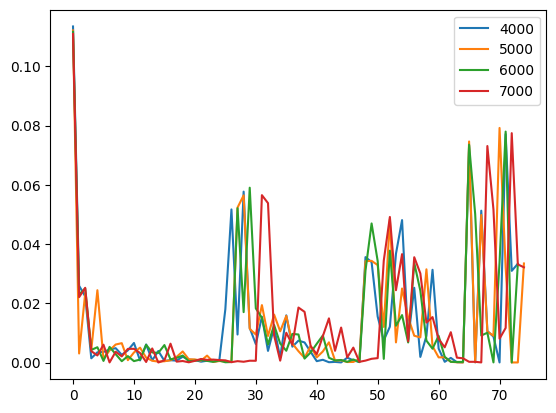

In [75]:
Wolff_cluster_Proposal_matrix(problem_inst=problem_inst)

Starting problem instance 1 of 5 with n = 3
Instance 1, T = 1, Proposal = Wolff_cluster_update, Acceptance = metropolis, Gap = 0.2192


C:\Users\vinit\AppData\Local\Temp\ipykernel_22796\4183202162.py:94: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results,pd.DataFrame([results_datum])], ignore_index=True)


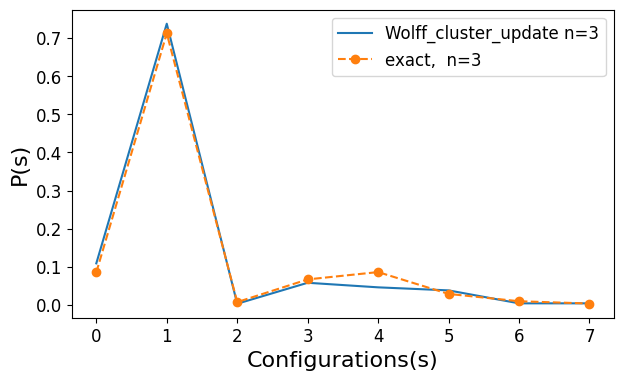

Starting problem instance 2 of 5 with n = 4
Instance 2, T = 1, Proposal = Wolff_cluster_update, Acceptance = metropolis, Gap = 0.0099


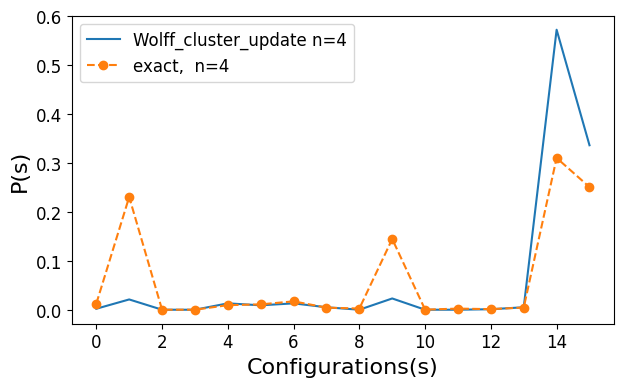

Starting problem instance 3 of 5 with n = 5
Instance 3, T = 1, Proposal = Wolff_cluster_update, Acceptance = metropolis, Gap = 0.0455


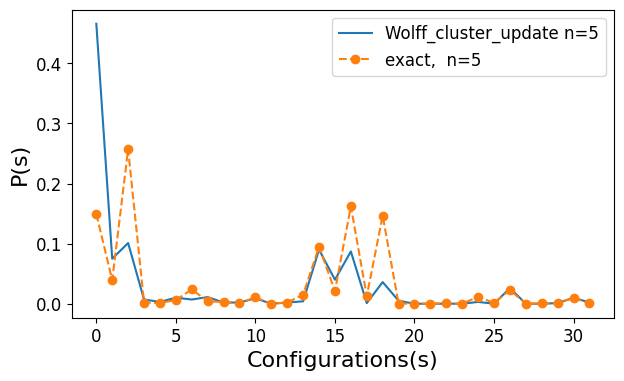

Starting problem instance 4 of 5 with n = 6
Instance 4, T = 1, Proposal = Wolff_cluster_update, Acceptance = metropolis, Gap = 0.0075


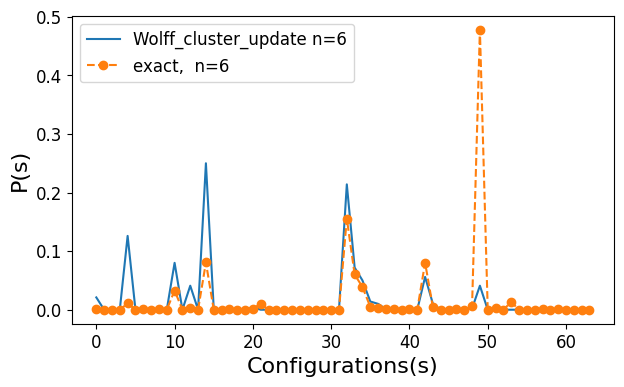

Starting problem instance 5 of 5 with n = 7
Instance 5, T = 1, Proposal = Wolff_cluster_update, Acceptance = metropolis, Gap = 0.0146


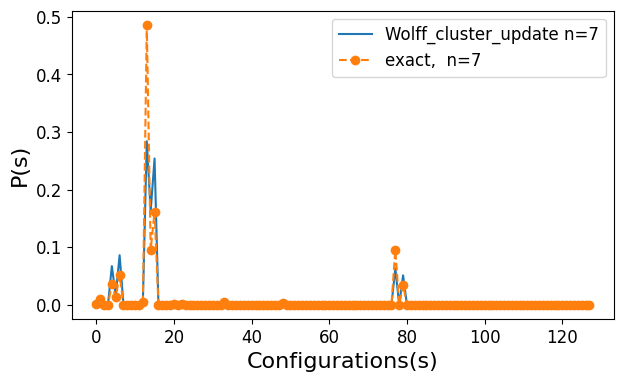

In [14]:
filepath = '/Users/vinit/Downloads/Research/Quantum-Sampling/Manas\' Proposals/'
filename_instances =  '/instances_new.pkl'
sample_size=1000

from tqdm import tqdm
instances = pd.read_pickle(filepath + filename_instances)
#tot_instances = np.max(instances['Instance Number'].values)
tot_instances = 5
results = pd.DataFrame(columns = [
    'Instance Number',
    'Spins', 
    'Temperature', 
    'Connectivity',
    'Proposal',
    'Acceptance',
#    'Mismatched',
    'Gap',
    'Gap Lazy'
        ])
T_logmesh = np.logspace(-3, 3, 50)
T_round = np.sort( np.kron(np.array([1,5]), 10.**np.arange(-3,4)))
T_lim = np.array([0, np.inf]) 
T_arr = np.unique( np.concatenate((T_logmesh, T_round, T_lim))) 
#T_arr = np.delete(T_arr, -2) 
T_arr = [1]
delta_step = 0.2


for instance_num in range(1, tot_instances+1):
    cond  = (instances['Instance Number']==instance_num)
    n            = instances[cond]['Spins'].values[0]
    connectivity = instances[cond]['Connectivity'].values[0]
    J            = instances[cond]['J'].values[0]
    h            = instances[cond]['h'].values[0]
    #J_mismatch   = instances[cond]['J Mismatch'].values[0]
    #h_mismatch   = instances[cond]['h Mismatch'].values[0]

    print('Starting problem instance', instance_num, 'of', tot_instances, 'with n =', n)

    problem_inst = ProblemInstance(J, h)
    #problem_inst_mismatch = ProblemInstance(J_mismatch, h_mismatch)
    #proposal_mats['quantum_avg'] = quantum_proposal_mat_avg(problem_inst)
    #proposal_mats['quantum_time_mid_gamma_mid'] = quantum_proposal_time_homogeneous(problem_inst, t_val="t_mid")
    #proposal_mats['quantum_time_mid_gamma_mid_Trotter'] = quantum_proposal_time_homogeneous_Trotter_circuit(problem_inst, delta_step, t_val="t_mid")
    
    #proposal_mats['quantum_time_uplim_gamma_mid'] = quantum_proposal_time_homogeneous(problem_inst, t_val="t-uplim")
    #proposal_mats['quantum_time_lowlim_gamma_mid'] = quantum_proposal_time_homogeneous(problem_inst, t_val="t-llim")

    #norm_diff_trotter_exact_proposal = np.linalg.norm(proposal_mats['quantum_time_mid_gamma_mid_Trotter']-proposal_mats['quantum_time_mid_gamma_mid'])
    #norm_exact_proposal = np.linalg.norm(proposal_mats['quantum_time_mid_gamma_mid'])

    for T in T_arr:
        problem_inst.T = T
        #problem_inst_mismatch.T = T 
        proposal_mats={}
        proposal_mats['Wolff_cluster_update'] = Wolff_cluster_Proposal_matrix(problem_inst)

        #for prop_type, accept_type in product(['local', 'uniform', 'quantum'], ['metropolis', 'glauber']):
        for prop_type, accept_type in product(['Wolff_cluster_update'], ['metropolis']):   #'local', 'uniform', 'quantum_avg', 'Wolff_cluster_update'   #'Haar', "Continuous-HMC", "adaptive_MC", "MALA_MC", 'quantum_time_mid_gamma_mid_Trotter',                
            # if prop_type == "Continuous-HMC":
            #     transition_mat = HMC_T_matrix(problem_inst, epsilon=0.2, L=10, alpha=3.0, num_samples=300, num_p_samples=30)

            # elif prop_type == "adaptive_MC":
            #     transition_mat = adaptive_metropolis_T_matrix(problem_inst, alpha=3.0, epsilon=0.2, num_samples=1000)

            # elif prop_type == "MALA_MC":
            #     transition_mat = adaptive_MALA_T_matrix(problem_inst, alpha=3.0, epsilon=0.2, num_samples=1000)

            transition_mat = make_transition_mat(problem_inst, proposal_mats[prop_type], acceptance=accept_type)
            
            if prop_type == '2-local':
                dist = np.sort( 1-np.abs(la.eigvals(transition_mat)) )
                gap = np.min(dist[2:])
            else:
                gap, _ = abs_spectral_gap(transition_mat)

            results_datum = {
                'Instance Number': instance_num,
                'Spins': n, 
                'Temperature': T, 
                'Connectivity': connectivity,
                'Proposal': prop_type,
                'Acceptance': accept_type,
                'Mismatched': False,
                'Gap': gap,
                "delta_time_step_Trotter": delta_step
            }

            #print(results_datum)

            print("Instance {}, T = {}, Proposal = {}, Acceptance = {}, Gap = {:.4f}".format(
                instance_num, T, prop_type, accept_type, gap))
            
            results = pd.concat([results,pd.DataFrame([results_datum])], ignore_index=True)

            
            # Proposal_object = All_proposals(inverse_temp=problem_inst.T, one_body_coeffs=problem_inst.h_quantum,
            #                two_body_coeffs = problem_inst.J_quantum)
            # print(sum(T[16,:]))
            # empirical_dist, key_list = Sampling_MCMC_trajectories(Proposal_object, 
            #                                      Transition_matrix=transition_mat, sample_size=sample_size, burn=sample_size//10)

            if prop_type in ['quantum_time_mid_gamma_mid_Trotter', 'Wolff_cluster_update',
                                            "Continuous-HMC", "adaptive_MC", "MALA_MC"]:
                empirical_dist, key_list = Sampling_MCMC_trajectories(problem_inst, 
                                                    Transition_matrix=transition_mat, sample_size=sample_size, burn=sample_size//10)

                fig, ax = plt.subplots(1, figsize=(7,4))
                if prop_type == 'quantum_time_mid_gamma_mid_Trotter':
                    prop_type = 'quantum_circ'
                ax.plot(empirical_dist, label=prop_type + ' n={}'.format(problem_inst.n))
                exact_dist = np.exp(-problem_inst.T*problem_inst.E_arr[::-1])
                exact_dist = exact_dist / np.sum(exact_dist)

                ax.plot(exact_dist, marker='o', linestyle='dashed', label='exact,  n={}'.format(problem_inst.n))
                
                ax.set_xlabel("Configurations(s)", fontsize=16)
                ax.set_ylabel("P(s)", fontsize=16)
                ax.legend(loc='best', fontsize=12)
                ax.tick_params(axis='both', which='major', labelsize=12)
                plt.savefig(os.getcwd() + "/Figures/{}_vs_configs_n_{}.png".format(prop_type, problem_inst.n), bbox_inches='tight')
                plt.show()

#results.to_pickle('results_new_all_prop.pkl')

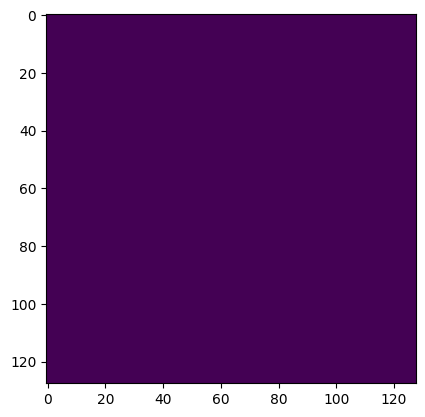

In [15]:
plt.imshow(transition_mat<0)

{'Instance Number': 1000,
 'Spins': 10,
 'Temperature': 1,
 'Connectivity': 'full',
 'Proposal': '2-local',
 'Acceptance': 'metropolis',
 'Mismatched': False,
 'Gap': 8.109154811308805e-06,
 'delta_time_step_Trotter': 0.2}

In [ ]:
results.to_csv('results_all_prop.csv', mode='a', header=not os.path.exists('results_all_prop.csv'), index=False)